### LDI (Liability driven investment)

### 프로그래밍 환경 설정
 - 데이터 라이브러리 지정
 - 한글 관련 설정 등

In [3]:
!pip install numpy_financial


In [4]:
## 사용자 정의 모듈 업데이트시마다 자동 load

%load_ext autoreload
%autoreload 2

### 공통 라이브러리 입수
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.font_manager as fm

from IPython.display import display

import os
import sys

# ### 시계열 예측 라이브러리
# from sklearn.metrics import mean_squared_error
# from pmdarima import auto_arima

### 금융 / 경제 데이터
import yfinance as yf
# from fredapi import Fred

### 금융 / 경제 함수
import numpy_financial as npf
from pyxirr import xirr

### 통계함수
from scipy.stats import norm
from scipy.stats import jarque_bera
from scipy.optimize import minimize
# from scipy.optimize import newton
# from numpy.linalg import inv

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

### 인터넷 접속 라이브러리 (한국은행,통계청)
import requests

### 그래프 셋팅 (runtime configuration parameters (rcParams))
# plt.rcParams['font.family'] ='Malgun Gothic'  # 한글 깨짐 방지
# plt.rcParams['axes.unicode_minus'] = False    # 마이너스 부호 깨짐 방지
plt.style.use('ggplot')                       # 그래프 스타일

### 사용자 정의 모듈 import
import PM_Tool_Kit_2025 as pk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### LDI의 응용 : 개인 생애 설계

시나리오
 - 현재연령 40세, 기대수명 90세
 - 현재 자산은 5억, 연봉은 1억 (세후)
 - 1년에 지출은 7천만원. 향후 지출은 연봉의 70% 정도로 유지
 - 아직 전세. 올해 5억 정도 대출해서 주택 구매 예정. 대출 금리는 3%, 40년 모기지 가정
 - 예상 퇴직연령은 55세. 퇴직시 예상 연봉은 1.5억. 매년 균등하게 증가하는 것으로 가정
 - 퇴직후 필요 최소 생활비는 300만원. 희망 생활비는 500만원. 퇴직시점 이후 연간 물가상승률은 2%
 - 예상 국민연금 수급연령은 65세, 수급액 예상액은 200만원
 - 퇴직연금은 퇴직 후 20년간 수령

- 이 사람의 플랜을 LDI 관점에서 정리해 보자

### 시뮬레이션 가정

In [5]:
### 가정

### 연령
my_age = 40
life_expectancy = 90
retire_age = 55
nat_pension_age = 65

### 근로소득
current_wage = 10000
terminal_wage = 15000

### 국민연금
ann_nat_pension = 2400
nat_pension_growth = 0.02

### 퇴직연금
cb_rate = 1/12 # 임금 대비 기여율 
receive_years = 20
ret_pension_rate = 0.03 # 퇴직연금 운용수익률

### 재직중 생활비
expense_ratio = 0.7 # 소득 중 소비지출 비율

### 아파트 대출
apt_loan = 50000
n_mtge = 40
loan_rate = 0.04

### 은퇴후 생활비
ret_living_expense = 3600 # 월 300
ret_liv_exp_growth = 0.02 # 생활비 증가율

### 현가 할인율
discount_rate = 0.04

### 기타
init_asset = 50000  ## 현재 보유자산

### 소득-지출 데이터셋 작성

In [6]:
### 빈 데이터셋 정의
df_income = pd.DataFrame(columns = ['wage','nat_pension','ret_pension_cb','ret_pension_cb_fv','ret_pension'], index = np.arange(40,91,1), dtype = 'float64')
df_income = df_income.fillna(0)

df_expense = pd.DataFrame(columns = ['living_expense','apt_loan','retire_expense'], index = np.arange(40,91,1), dtype = 'float64')
df_expense = df_expense.fillna(0)

### 소득 플로우 정의

## 임금소득
df_income.loc[my_age:retire_age,'wage'] = np.linspace(current_wage,terminal_wage,retire_age - my_age + 1)   

## 국민연금
df_income.loc[nat_pension_age:life_expectancy,'nat_pension'] = \
  [ann_nat_pension * ((1+nat_pension_growth) ** (year -nat_pension_age)) \
    for year in range(nat_pension_age,life_expectancy+1)]  

## 퇴직연금기여액
df_income.loc[my_age:retire_age,'ret_pension_cb'] = \
  df_income.loc[my_age:retire_age,'wage'] * cb_rate 

## 퇴직연금미래가치
df_income.loc[my_age:retire_age,'ret_pension_cb_fv'] = \
  df_income.loc[my_age:retire_age,'ret_pension_cb'] * (1+ret_pension_rate) ** (retire_age - df_income.loc[my_age:retire_age].index)  ## (1/12 = 8.33% + 일부 운용수익)

### 퇴직연금 연간 수입금액 산출
ret_pension_os = df_income['ret_pension_cb_fv'].sum()
annual_withdrawal = npf.pmt(ret_pension_rate, receive_years, -ret_pension_os)  ## 퇴직연금은 20년간 수령 가정
df_income.loc[retire_age + 1:retire_age + receive_years,'ret_pension'] = annual_withdrawal

### 지출 플로우 정의

## 은퇴전 생활비
df_expense.loc[my_age:retire_age,'living_expense'] = \
    df_income.loc[my_age:retire_age,'wage'] * expense_ratio   ## 가능혀?

## 은퇴후 생활비
df_expense.loc[retire_age+1:life_expectancy,'retire_expense'] = \
    [ret_living_expense * ((1+ret_liv_exp_growth) ** (year - (retire_age+1))) \
     for year in range(retire_age+1,life_expectancy+1)]

## 모기지 연간 상환액
df_expense.loc[my_age:my_age+n_mtge-1,'apt_loan'] = npf.pmt(loan_rate,n_mtge,-apt_loan) 

### 수입 / 지출 하나의 df로
df_my_flow = pd.concat([df_income,-df_expense],axis = 1).drop(columns = 'ret_pension_cb')
df_my_flow['surplus'] = df_my_flow.sum(axis = 1)

display(df_income)
display(df_expense)
display(df_my_flow)
                                       

,wage,nat_pension,ret_pension_cb,ret_pension_cb_fv,ret_pension
40,10000.000000,0.000000,833.333333,1298.306181,0.00000
41,10333.333333,0.000000,861.111111,1302.507819,0.00000
42,10666.666667,0.000000,888.888889,1305.363301,0.00000
43,11000.000000,0.000000,916.666667,1306.947480,0.00000
44,11333.333333,0.000000,944.444444,1307.331989,0.00000
45,11666.666667,0.000000,972.222222,1306.585369,0.00000
46,12000.000000,0.000000,1000.000000,1304.773184,0.00000
47,12333.333333,0.000000,1027.777778,1301.958139,0.00000
48,12666.666667,0.000000,1055.555556,1298.200191,0.00000
49,13000.000000,0.000000,1083.333333,1293.556655,0.00000


,living_expense,apt_loan,retire_expense
40,7000.000000,2526.174466,0.000000
41,7233.333333,2526.174466,0.000000
42,7466.666667,2526.174466,0.000000
43,7700.000000,2526.174466,0.000000
44,7933.333333,2526.174466,0.000000
45,8166.666667,2526.174466,0.000000
46,8400.000000,2526.174466,0.000000
47,8633.333333,2526.174466,0.000000
48,8866.666667,2526.174466,0.000000
49,9100.000000,2526.174466,0.000000


,wage,nat_pension,ret_pension_cb_fv,ret_pension,living_expense,apt_loan,retire_expense,surplus
40,10000.000000,0.000000,1298.306181,0.00000,-7000.000000,-2526.174466,-0.000000,1772.131714
41,10333.333333,0.000000,1302.507819,0.00000,-7233.333333,-2526.174466,-0.000000,1876.333352
42,10666.666667,0.000000,1305.363301,0.00000,-7466.666667,-2526.174466,-0.000000,1979.188835
43,11000.000000,0.000000,1306.947480,0.00000,-7700.000000,-2526.174466,-0.000000,2080.773013
44,11333.333333,0.000000,1307.331989,0.00000,-7933.333333,-2526.174466,-0.000000,2181.157523
45,11666.666667,0.000000,1306.585369,0.00000,-8166.666667,-2526.174466,-0.000000,2280.410903
46,12000.000000,0.000000,1304.773184,0.00000,-8400.000000,-2526.174466,-0.000000,2378.598718
47,12333.333333,0.000000,1301.958139,0.00000,-8633.333333,-2526.174466,-0.000000,2475.783673
48,12666.666667,0.000000,1298.200191,0.00000,-8866.666667,-2526.174466,-0.000000,2572.025725
49,13000.000000,0.000000,1293.556655,0.00000,-9100.000000,-2526.174466,-0.000000,2667.382188


### 근로소득 / 지출의 funding ratio 산출 (LHP)

In [7]:
### 수입 / 지출 현가화 하여 funding ratio 산출
### LHP의 funding ratio라 할 수 있을 것임

def pv_cf(discount_rate,cash_flows):

  df_discount = pd.DataFrame(columns = ['discount_factor','cash_flow','dcf'],index = df_income.index, dtype = 'float64')
  for i in df_discount.index:
    df_discount.loc[i,'discount_factor'] = 1/((1+discount_rate) ** (i-40))
  df_discount['cash_flow'] = cash_flows
  df_discount['dcf'] = df_discount['discount_factor'] * df_discount['cash_flow']

  return df_discount

df_income_sum = df_income['wage'] + df_income['nat_pension'] + df_income['ret_pension']
df_expense_sum = df_expense['living_expense'] + df_expense['retire_expense'] + df_expense['apt_loan']

pv_income = pv_cf(discount_rate,df_income_sum)['dcf'].sum()
pv_expense = pv_cf(discount_rate,df_expense_sum)['dcf'].sum()

print(f'present value of future income : {pv_income:.0f}\n')
print(f'present value of future expense : {pv_expense:.0f}\n')
print(f'funding ratio : {pv_income/pv_expense:.0%}\n')
print(f'surplus : {(pv_income - pv_expense):.0f}')

present value of future income : 177166

present value of future expense : 204988

funding ratio : 86%

surplus : -27823


### 이제 모자란 펀딩을 채우기 위해 PSP가 얼마나 필요한지 생각해 보자

In [8]:
### 파라메터 정의
### 번 돈은 모두 재투자 한다
### 기초에 투자

### 초기투자액
psp_loan = 30000

### 투자기간 
investment_span = 25
# psp_rtn = np.repeat(0.10,investment_span)

### 조달금리
psp_loan_rate = 0.04

### 할인율
discount_rate = 0.04

### 운용수익률
psp_rtn = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

In [9]:
print(psp_rtn)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [10]:
df_psp = pd.DataFrame(columns = ['inv_amt_st','inv_return','intr_paid','cash_inflow','inv_amt_lt','discount_factor'],index = range(0,investment_span),dtype = 'float64')

for i in df_psp.index:
  if i == 0:
    df_psp.loc[i,'inv_amt_st'] = psp_loan
  else:
    df_psp.loc[i,'inv_amt_st'] = df_psp.loc[i-1,'inv_amt_lt']

  df_psp.loc[i,'inv_return'] = df_psp.loc[i,'inv_amt_st'] * psp_rtn[i]
  df_psp.loc[i,'intr_paid'] = psp_loan * psp_loan_rate
  df_psp.loc[i,'cash_inflow'] = df_psp.loc[i,'inv_return'] - df_psp.loc[i,'intr_paid']
  df_psp.loc[i,'inv_amt_lt'] = df_psp.loc[i,'inv_amt_st'] + df_psp.loc[i,'cash_inflow']
  df_psp.loc[i,'discount_factor'] = 1 / (1+discount_rate)**(i+1)


In [11]:
## 투자액의 현재가치
pv_psp = df_psp['inv_amt_lt'].iloc[-1] * df_psp['discount_factor'].iloc[-1]
print(f'pv of investment : {pv_psp:.0f}\n')


pv of investment : 77658



In [12]:
display(df_psp)

,inv_amt_st,inv_return,intr_paid,cash_inflow,inv_amt_lt,discount_factor
0,30000.000000,3000.000000,1200.0,1800.000000,31800.000000,0.961538
1,31800.000000,3180.000000,1200.0,1980.000000,33780.000000,0.924556
2,33780.000000,3378.000000,1200.0,2178.000000,35958.000000,0.888996
3,35958.000000,3595.800000,1200.0,2395.800000,38353.800000,0.854804
4,38353.800000,3835.380000,1200.0,2635.380000,40989.180000,0.821927
5,40989.180000,4098.918000,1200.0,2898.918000,43888.098000,0.790315
6,43888.098000,4388.809800,1200.0,3188.809800,47076.907800,0.759918
7,47076.907800,4707.690780,1200.0,3507.690780,50584.598580,0.730690
8,50584.598580,5058.459858,1200.0,3858.459858,54443.058438,0.702587
9,54443.058438,5444.305844,1200.0,4244.305844,58687.364282,0.675564


### 이제 PSP가 확률적이라고 생각해 보자..연 10% 이익낼려면 Sharpe ratio 0.5 감안하면 14% 변동성 (rf = 3%)

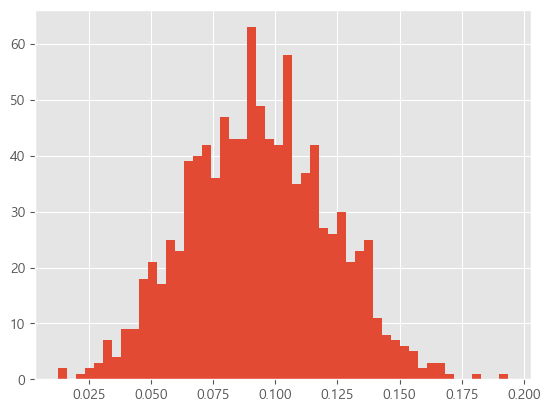

In [13]:
### 시뮬레이션 연습

# 파라미터 설정
mu = 0.1              # 기대 수익률 10%
sigma = 0.14          # 변동성 14%
r_f = 0.03            # 무위험 수익률 3%
T = 25                # 투자 기간 25년
n_simulations = 1000  # 시뮬레이션 수
dt = 1                # 연 단위 시뮬레이션이므로 1년 간격

# 초기 주가 설정 (예: 100)
S0 = 50000

# 시뮬레이션 결과 저장
simulations = np.zeros((T + 1, n_simulations))
simulations[0] = S0

# 시뮬레이션 실행
for i in range(n_simulations):
    for t in range(1, T + 1):
        Z = np.random.normal(0, 1)  # 표준 정규분포 난수 생성
        # 주가의 다음 값 계산 (무위험 수익률을 포함한 GBM 모델)
        simulations[t, i] = simulations[t - 1, i] * np.exp((mu - r_f - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

# 결과를 데이터프레임으로 변환
df_simulations = pd.DataFrame(simulations)
interest_rates = df_simulations.pct_change().iloc[1:] + r_f  # 첫 번째 연도 제외 후 수익률 계산

test1 = ((1+interest_rates).prod())**(1/25)-1
test1.hist(bins = 50);



In [14]:
display (interest_rates)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,0.176398,-0.114329,0.065423,0.271913,0.119388,0.143875,0.010962,0.260912,-0.237723,0.135105,...,0.289743,0.106065,-0.052272,0.137654,0.089431,0.112546,-0.067970,0.085663,-0.044885,0.215005
2,0.218247,-0.027734,0.040142,0.171696,0.261098,0.099660,0.263595,0.122687,0.087851,0.022486,...,0.409810,-0.070676,0.168553,0.248844,-0.026839,-0.039022,-0.141099,0.103325,0.086937,0.007839
3,0.389344,0.479648,-0.130546,0.155371,-0.075531,0.255163,-0.099369,0.026207,0.005512,0.348041,...,-0.045172,0.156330,0.035052,0.199291,0.219953,0.049073,0.254743,0.200771,0.123487,0.426486
4,0.098876,0.191935,-0.037223,0.299029,-0.057130,0.201856,-0.039762,-0.142876,-0.066674,0.252029,...,0.107768,0.154630,0.224934,0.071055,-0.057185,0.079108,0.160112,-0.027736,0.106707,0.039999
5,0.002669,0.085673,0.020672,0.220490,0.052250,0.423627,0.034063,0.158510,-0.009924,-0.088142,...,0.281786,0.146048,0.306417,0.242575,0.121279,0.283971,-0.087568,0.560737,-0.062703,0.124288
6,-0.022817,0.083501,0.096935,0.012962,0.259923,0.318821,0.101076,0.111625,-0.192737,0.534642,...,-0.114320,-0.076423,0.004780,0.197374,-0.085906,0.016038,0.070992,0.175486,0.291241,0.033722
7,-0.053196,-0.076752,0.279065,0.029252,-0.001724,-0.052964,-0.008481,0.232349,0.070445,0.047682,...,-0.353446,0.319384,-0.003252,0.228525,0.194177,0.190349,0.176418,0.216010,0.348829,0.033322
8,0.009552,0.015235,-0.206027,-0.008797,-0.014573,0.101670,0.307628,0.375920,-0.000109,-0.248898,...,-0.088003,0.244121,0.050142,0.033558,-0.018545,0.059617,0.037643,0.346088,-0.050038,0.258800
9,0.192279,0.085785,0.048422,0.374554,-0.137313,0.300262,-0.006148,0.295960,0.234283,0.120336,...,0.248941,0.006724,-0.034709,0.279798,0.011942,0.109030,0.271440,0.155217,0.369983,0.021983
10,0.041905,-0.043270,0.235277,0.072565,0.337997,0.211896,0.086733,0.174377,0.203548,0.251007,...,-0.177792,0.055021,0.314758,0.201220,0.363844,0.024825,0.038632,0.349006,0.211718,0.384642


In [15]:
psp_loan = 30000
investment_span = 25
# psp_rtn = np.repeat(0.10,investment_span)
psp_loan_rate = 0.04
discount_rate = 0.04
psp_rtn = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

def psp_simulation(psp_loan,investment_span,psp_rtn,psp_loan_rate,discount_rate):

  df_psp = pd.DataFrame(columns = ['inv_amt_st','inv_return','intr_paid','cash_inflow','inv_amt_lt','discount_factor'],index = range(0,investment_span),dtype = 'float64')

  for i in df_psp.index:
    if i == 0:
      df_psp.loc[i,'inv_amt_st'] = psp_loan
    else:
      df_psp.loc[i,'inv_amt_st'] = df_psp.loc[i-1,'inv_amt_lt']

    df_psp.loc[i,'inv_return'] = df_psp.loc[i,'inv_amt_st'] * psp_rtn[i]
    df_psp.loc[i,'intr_paid'] = psp_loan * psp_loan_rate
    df_psp.loc[i,'cash_inflow'] = df_psp.loc[i,'inv_return'] - df_psp.loc[i,'intr_paid']
    df_psp.loc[i,'inv_amt_lt'] = df_psp.loc[i,'inv_amt_st'] + df_psp.loc[i,'cash_inflow']
    df_psp.loc[i,'discount_factor'] = 1 / (1+discount_rate)**(i+1)

  pv_psp = df_psp['inv_amt_lt'].iloc[-1] * df_psp['discount_factor'].iloc[-1]

  return pv_psp

value_psp = psp_simulation(psp_loan,investment_span,psp_rtn,psp_loan_rate,discount_rate)
print(f'pv of total : {value_psp:.0f}\n')



pv of total : 77658



,pv_total
0,80189.820181
1,48422.006070
2,29681.831496
3,198183.904163
4,47772.671846
...,...
995,55262.330085
996,48883.090116
997,145870.623666
998,160380.836737


투자 현재가치의 평균 기대값 : 82715.84077787041
투자 현재가치가 원금보다 적은 경우의 갯수 : pv_total    194
dtype: int64


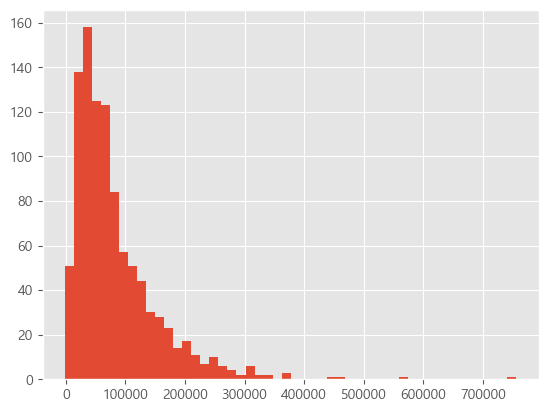

In [16]:
n_simulation = interest_rates.shape[1]
psp_result = pd.DataFrame(columns = ['pv_total'],index = interest_rates.columns,dtype = 'float64')

for i in range(0,n_simulations):

  psp_rtn = interest_rates.iloc[:,i].to_numpy()
  value_psp = psp_simulation(psp_loan,investment_span,psp_rtn,psp_loan_rate,discount_rate)
  psp_result.loc[i,'pv_total'] = value_psp

display(psp_result)
psp_result['pv_total'].hist(bins=50)

psp_mean = psp_result['pv_total'].mean()
print(f'투자 현재가치의 평균 기대값 : {psp_mean}')

psp_cnt = psp_result[psp_result['pv_total'] < psp_loan].count()
print(f'투자 현재가치가 원금보다 적은 경우의 갯수 : {psp_cnt}')


### 수고하셨습니다!!